In [1]:
# # aws dependencies
# %pip install awswrangler

# # guara dependencies
# %pip install lightgbm
# %pip install shap
# %pip install optuna
# %pip install great_expectations
# %pip install unidecode

In [ ]:
# general libs
import os
import re
import sys
import nltk 
import heapq
import boto3
import string
import difflib
import sagemaker
import numpy as np 
import pandas as pd
import seaborn as sn
import awswrangler as wr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
nltk.download('punkt')

# guara libs
from sklearn.pipeline import Pipeline
sys.path.append(os.path.dirname(os.getcwd())+'/src')
from get_data import GetData
from guara.modeling.supervised_modelz import SupervisedModelz

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/ec2-user/anaconda3/envs/chainer_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Load data

In [ ]:
full_df = GetData().get_input_data()
full_df

# Modelagem

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

In [5]:
import nltk
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.util import bigrams
from nltk.misc import babelize_shell
from unidecode import unidecode
from nltk import tokenize

def GetYearBasis(X, col='dataliberacao'):
    assert isinstance(X, pd.DataFrame)

    dataset_list = []
    for year in sorted(set(X[col].dt.year)):
        X_aux = X.copy()
        X_aux[col] = pd.to_datetime(X[col])
        X_aux = X_aux[X_aux[col].dt.year == year]
        dataset_list.append(X_aux)
        
    return dataset_list


def processa_texto_(texto, return_ = 'string'):
    # stemmer = nltk.stem.RSLPStemmer()
    stemmer = nltk.stem.SnowballStemmer(language = 'portuguese')
    stopwords=nltk.corpus.stopwords.words('portuguese')
   


    # separa em palavras
    token = tokenize.word_tokenize(texto.lower(), language='portuguese')
    # retira stopwords
    token = [word for word in token if word not in stopwords]
    # retira palavras pre selecionadas
    #token = [word for word in token if len(word) > 2]
    # retira numeros 
    token = [ word if word.isalpha() else '#NUM' for word in token ]
    # tira caracteres especiais  e faz stemmizacao
    token = [unidecode(stemmer.stem(word)) for word in token]

    if return_ == 'string':
        return ' '.join(token)
    elif return_ == 'list':
        return token

    
class ProcessaTexto(BaseEstimator, TransformerMixin):

    def __init__(self, col):
        self.col=col
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
     
        X['texto_tratado'] = X[self.col].replace('\§', ' ENTER ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace(['\"', '-'], '', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace(['\"', '\*'], ' ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].replace([ '\/', '\.', '\,', '\;'], ' punkt ', regex = True)
        X['texto_tratado'] = X['texto_tratado'].apply(lambda x: processa_texto_(x))
        
        return X

In [6]:
class CountVectorizerPandas(BaseEstimator, TransformerMixin):
    """
    Performs bag of words on a column
    args:
        max_features: maximum number of features
    
    """  
    
    def __init__(self, max_features):
        self.cv = None
        self.max_features = max_features
        
    def fit(self, X, y=None):
        
        self.col = 'texto_tratado'
        
        self.cv =  CountVectorizer(max_features=self.max_features)
                           
        self.cv.fit(X[self.col])
        
        return self


    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        
        Xt = self.cv.transform(X[self.col]).todense()
        Xt = pd.DataFrame(Xt, columns = self.cv.get_feature_names(), index=X.index)
        
        return Xt  

In [7]:
# split dos dados - 70% para treino e 30% para validação

x_aux, x_test, y_aux, y_test = train_test_split(
    full_df[['laudo','texto']], 
    full_df['cancer'], 
    train_size=0.9, 
    shuffle=True,
    random_state=123
    )

x_train, x_val, y_train, y_val = train_test_split(
    x_aux, 
    y_aux, 
    train_size=0.7, 
    shuffle=True,
    random_state=123
    )


# aplicar pipeline com transformações
pipe = Pipeline([
    ('preproc', ProcessaTexto('texto')),
    ('bag', CountVectorizerPandas(max_features=250))
])

x_train = pipe.fit_transform(x_train)
x_val = pipe.transform(x_val)

In [8]:
x_train.head()  

,acentu,achad,acin,acomet,actin,adenocarcinom,adenom,adenos,agreg,alter,...,tod,transvers,tubul,tumor,ulcer,urol,usual,uterin,vascul,vid
4822,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,0,0
6425,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,2,0
3284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6126,2,3,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print('x_train shape: ', x_train.shape, 'y_train shape: ', y_train.shape)
print('x_test shape: ', x_val.shape, 'y_test shape: ', y_val.shape)
print('x_test shape: ', x_test.shape, 'y_test shape: ', y_test.shape)

x_train shape:  (4287, 250) y_train shape:  (4287,)
x_test shape:  (1838, 250) y_test shape:  (1838,)
x_test shape:  (681, 2) y_test shape:  (681,)


In [10]:
# modelagem
md = SupervisedModelz('lgbm', 'binary')

params = {
    'random_state': 501,
    'boosting_type': 'gbdt',
    'device_type': 'cpu',
    'is_unbalanced':'true',
    'learning_rate': 0.01,
    'colsample_bytree': 0.7,
    'max_depth': 20,
    'n_estimators': 500,
    'sub_sample': 0.8,
    'num_leaves': 10,
    'min_child_samples': 24,
 }

model = md.fit(x_train, x_val, y_train, y_val, params)

Treinando o modelo LGBM, objetivo BINARY... 

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] Number of positive: 1079, number of negative: 3208
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1670
[LightGBM] [Info] Number of data points in the train set: 4287, number of used features: 250
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: sub_sample
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.251691 -> initscore=-1.089613
[LightGBM] [Info] Start training from score -1.089613
Modelo treinado em 0.01 minutos 



Model best iteration: 500

BINARY_LOGLOSS loss:
Train: 0.0452
Val  : 0.0601


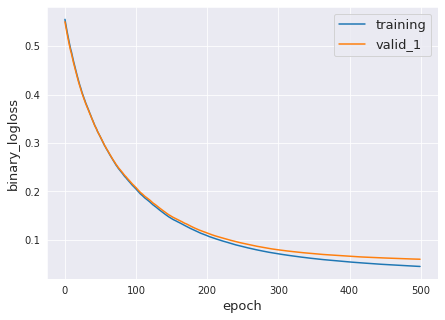

In [11]:
md.plot_train_info()

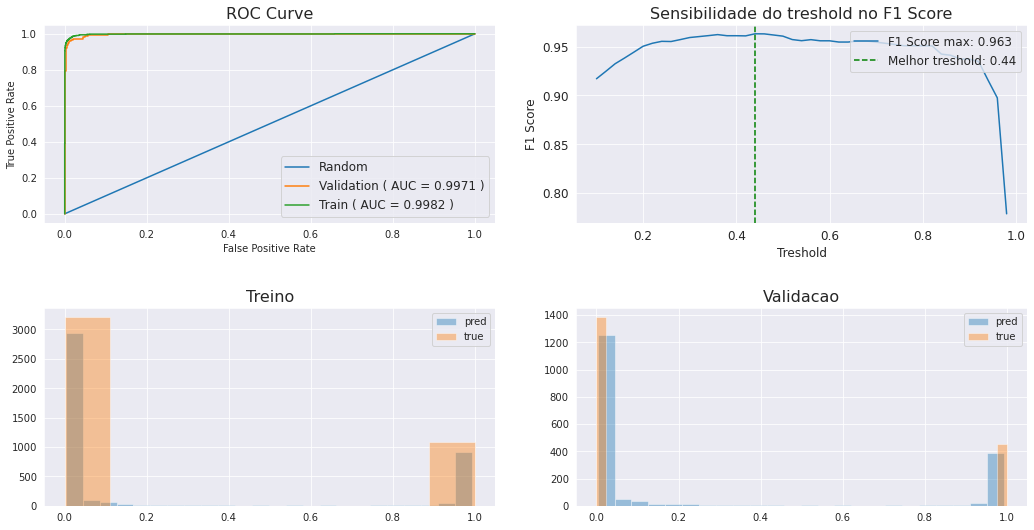

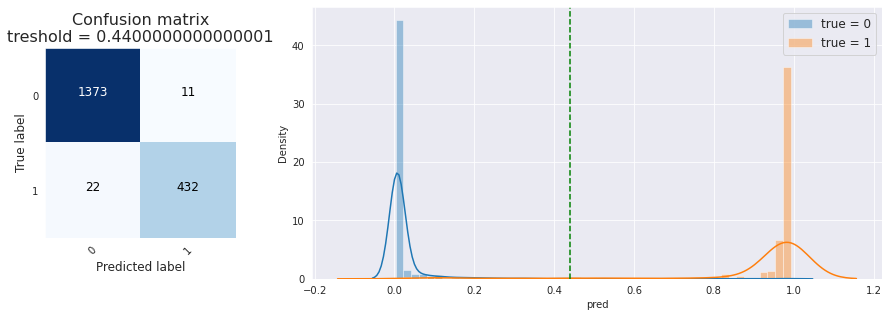


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1384
           1       0.98      0.95      0.96       454

    accuracy                           0.98      1838
   macro avg       0.98      0.97      0.98      1838
weighted avg       0.98      0.98      0.98      1838



In [12]:
ytrain_pred = md.predict(x_train)
yval_pred = md.predict(x_val)

md.evaluation_plots(y_train.values, ytrain_pred, y_val.values, yval_pred)

In [14]:
# shap
df_shap = md.init_shap(x_val)
df_shap.head()

,acentu,achad,acin,acomet,actin,adenocarcinom,adenom,adenos,agreg,alter,...,tod,transvers,tubul,tumor,ulcer,urol,usual,uterin,vascul,vid
0,0.0,0.0,0.0,0.0,0.0,-0.165184,0.000588,0.0,0.008215,0.0,...,-0.000525,0.0,0.0,-0.024858,-0.000179,0.0,0.0,0.0,-0.001541,0.000512
1,0.0,0.0,0.0,0.0,0.0,-0.166448,0.000588,0.0,0.007591,0.0,...,-0.000526,0.0,0.0,-0.024392,-0.000212,0.0,0.0,0.0,-0.001541,0.000316
2,0.0,0.0,0.0,0.0,0.0,-0.147021,0.000588,0.0,0.039217,0.0,...,-0.000413,0.0,0.0,-0.017932,-0.000212,0.0,0.0,0.0,-0.001512,0.000736
3,0.0,0.0,0.0,0.0,0.0,-0.163193,-0.001366,0.0,0.007592,0.0,...,-0.000508,0.0,0.0,-0.025939,-0.001683,0.0,0.0,0.0,-0.001541,0.000736
4,0.0,0.0,0.0,0.0,0.0,4.620022,0.001367,0.0,0.007410,0.0,...,-0.000234,0.0,0.0,-0.011135,-0.001683,0.0,0.0,0.0,0.031365,0.000688


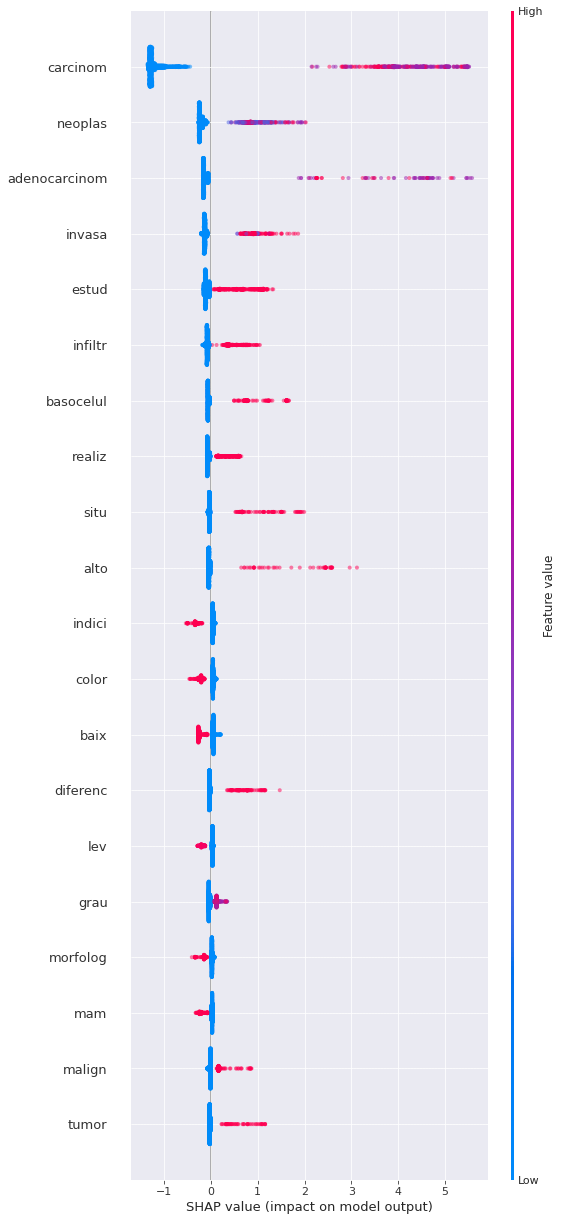

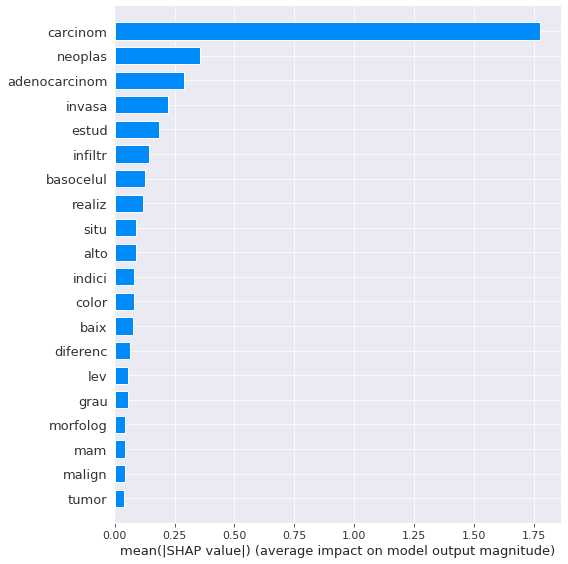

In [16]:
importance = md.shap_importance(x_val)

In [17]:
importance

carcinom         1.775832
neoplas          0.357790
adenocarcinom    0.287997
invasa           0.221180
estud            0.184490
                   ...   
foveol           0.000000
pern             0.000000
fundic           0.000000
gastric          0.000000
acentu           0.000000
Length: 250, dtype: float64

# Resultados com o dataset de teste

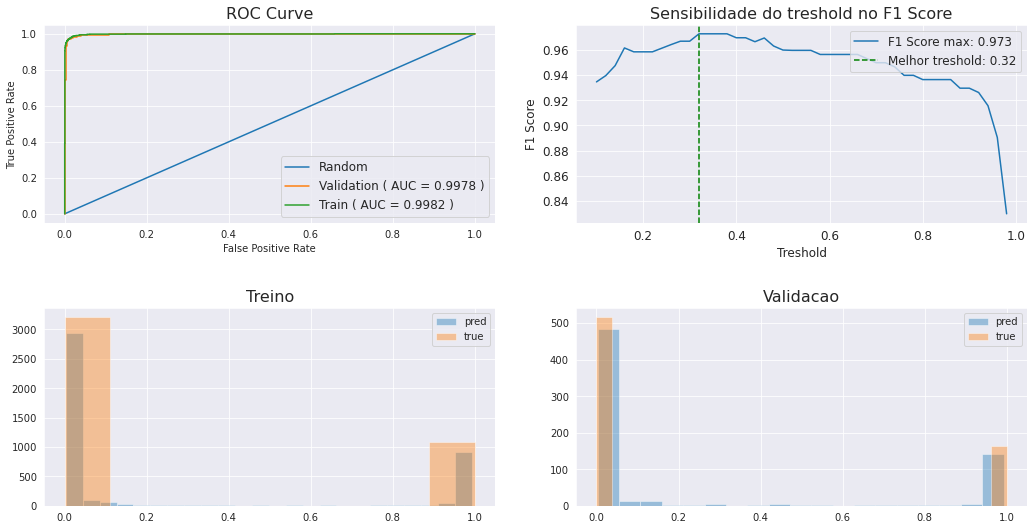

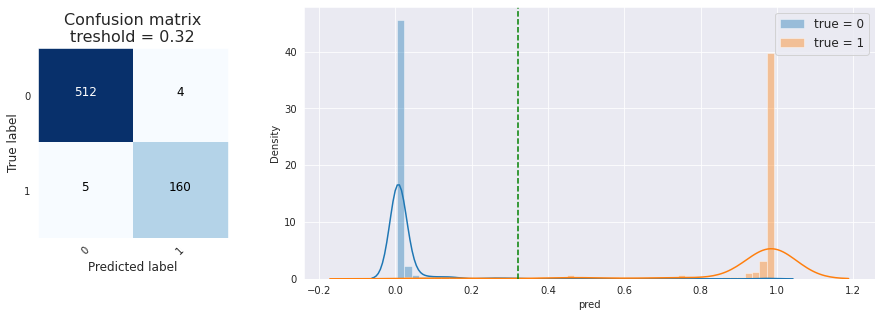


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       516
           1       0.98      0.97      0.97       165

    accuracy                           0.99       681
   macro avg       0.98      0.98      0.98       681
weighted avg       0.99      0.99      0.99       681



In [19]:
# test-set definition
x_test = pipe.transform(x_test)

ytrain_pred = md.predict(x_train)
ytest_pred = md.predict(x_test)

md.evaluation_plots(y_train.values, ytrain_pred, y_test.values, ytest_pred)